In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../lecture 2/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [18]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts


parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [21]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.1857
  10000/ 200000: 1.8734
  20000/ 200000: 1.9344
  30000/ 200000: 2.0513
  40000/ 200000: 2.2272
  50000/ 200000: 2.1511
  60000/ 200000: 2.1176
  70000/ 200000: 2.8093
  80000/ 200000: 2.6944
  90000/ 200000: 2.2984
 100000/ 200000: 2.2699
 110000/ 200000: 1.8550
 120000/ 200000: 2.1641
 130000/ 200000: 1.9782
 140000/ 200000: 1.8181
 150000/ 200000: 2.4424
 160000/ 200000: 2.2711
 170000/ 200000: 1.8003
 180000/ 200000: 1.9056
 190000/ 200000: 2.1542


In [22]:
#Now our loss doesn't look like a hockey stick. we're reducing initial loss

In [ ]:
logits[0] #these are the logits at the very first iteration of our training loop that gave us 27 loss. these should be much much much closer to 0

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [ ]:
logits[0] #better!

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

In [ ]:
#initialization loss is wayyyyy too high. since we expect a uniform distribution of letters in the beginning where they're each most likely, we expect the loss to be:
-torch.tensor(1/27.0).log() #27 is way higher than 3.29.

tensor(3.2958)

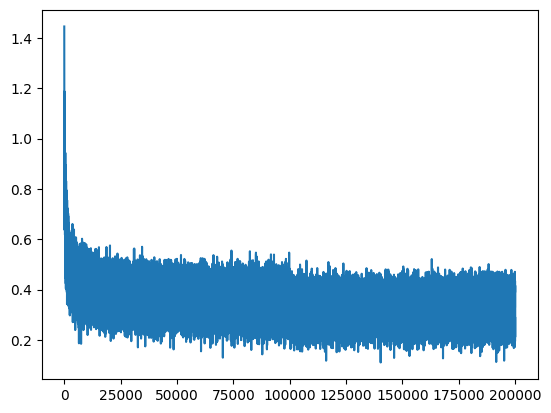

In [8]:
plt.plot(lossi)

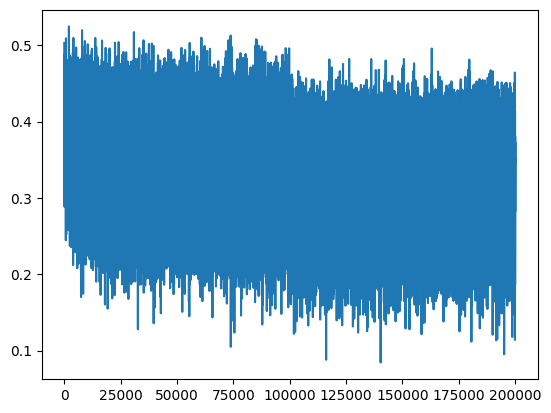

In [23]:
#old loss above before fixing
#new loss below after fixing
plt.plot(lossi)

In [9]:
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.1269264221191406
val 2.171828031539917


In [10]:
#sample from model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # init with all
    while True:
        #Forward pass the NN
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1+b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        #sample from dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track samples
        context = context[1:]+ [ix]
        out.append(ix)
        #if we sample the special "." token, break
        if ix == 0:
            break
    print(''.join(itos[i]for i in out))

carmah.
amelle.
khy.
mili.
taty.
skanden.
jazonte.
den.
art.
kaqaif.
ramari.
chaiivia.
legy.
dham.
jocca.
dint.
salin.
alianni.
waztho.
dearixi.


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts


parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() #disable gradient tracking. 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    emb = C[x]#(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, Nhidden)
    logits = h @ W2 + b2 # (N, vocab_size) 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


In [ ]:
#sample from model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # init with all
    while True:
        #Forward pass the NN
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1+b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        #sample from dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track samples
        context = context[1:]+ [ix]
        out.append(ix)
        #if we sample the special "." token, break
        if ix == 0:
            break
    print(''.join(itos[i]for i in out))